# Tarea 3 - MAN3160



**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.


En esta tarea, se utilizará la biblioteca DeepCTR-Torch para generar un sistema recomendador que utiliza información de contenido y contexto.

## Descarga del dataset

Nuevamente, se utilizará el dataset MovieLens-100k para esta tarea.

In [4]:
# !pip install wget
# !pip install zipfile36
# !pip3 install implicit --upgrade
# !python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !pip install deepctr-torch
# !pip install tensorflow

In [2]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [114]:
# Pueden importar más librerías si es necesario

import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse
import time
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from deepctr_torch.inputs import SparseFeat, VarLenSparseFeat, get_feature_names
from deepctr_torch.models import DeepFM

In [115]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [116]:
dir_train = 'ml-100k'

# Generamos los títulos de las columnas del archivo items.

columns = ['itemid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [117]:
df = pd.read_csv(f'{dir_train}/u.data',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

In [118]:
df_items = pd.read_csv(f'{dir_train}/u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None,
                        encoding='latin-1')

In [119]:
columns_user = ['userid', 'age', 'gender', 'occupation', 'zip_code']

In [120]:
df_users = pd.read_csv(f'{dir_train}/u.user',
                        sep='|',
                        index_col=0,
                        names = columns_user,
                        header=None,
                        encoding='latin-1')

df_users = df_users.reset_index()
df_items = df_items.reset_index()

In [121]:
df_total = pd.merge(df, df_users, on='userid')
df_total = pd.merge(df_total, df_items, on='itemid')

In [122]:
def combine_genres(row):
    genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    return '|'.join([col for col, val in row.items() if val == 1 and col in genres])

In [123]:
df_total['genres'] = df_total.apply(combine_genres, axis=1)

In [124]:
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
df_total = df_total.drop(genres, axis=1)

In [125]:
df_total.sort_values(by='timestamp').head(10)

,userid,itemid,rating,timestamp,age,gender,occupation,zip_code,title,release_date,video_release_date,IMDb_URL,unknown,genres
43056,259,255,4,874724710,21,M,student,48823,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,Comedy|Romance
1899,259,286,4,874724727,21,M,student,48823,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,Drama|Romance|War
17880,259,298,4,874724754,21,M,student,48823,Face/Off (1997),27-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Face/Off+(1997),0,Action|Sci-Fi|Thriller
58719,259,185,4,874724781,21,M,student,48823,Psycho (1960),01-Jan-1960,NaN,http://us.imdb.com/M/title-exact?Psycho%20(1960),0,Horror|Romance|Thriller
5563,259,173,4,874724843,21,M,student,48823,"Princess Bride, The (1987)",01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Princess%20Br...,0,Action|Adventure|Comedy|Romance
48244,259,772,4,874724882,21,M,student,48823,Kids (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Kids%20(1995),0,Drama
3747,259,108,4,874724882,21,M,student,48823,Kids in the Hall: Brain Candy (1996),12-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Kids%20in%20t...,0,Comedy
10683,259,288,3,874724905,21,M,student,48823,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,Horror|Thriller
88373,259,928,4,874724937,21,M,student,48823,"Craft, The (1996)",26-Apr-1996,NaN,"http://us.imdb.com/M/title-exact?Craft,%20The%...",0,Drama|Horror
10132,259,117,4,874724988,21,M,student,48823,"Rock, The (1996)",07-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%2...",0,Action|Adventure|Thriller


# Actividades

### Actividad 1: Análisis de características de contenido.

En el tutorial de DeepCTR-torch, se dio un ejemplo del entrenamiento de un modelo con DeepCTR-torch que combinó data de contexto y de contenido. En esta tarea, se realizará un procedimiento similar. Se les proporcionó el código para generar el dataframe df_total, el cual contiene todo los metadatos de contenido para cada interacción. Esta primera actividad se tratará de seleccionar los datos de contenido que usarán y realicen un análisis de ello. Lo que deben hacer es:

* Seleccionar las columnas de contenido que creen que proporcionan información que puede ser aprovechada por un algoritmo recomendador. Deben elegir al menos dos características del usuario y dos características de los ítems. Se debe indicar explícitamente la información seleccionada y entregar una breve justificación de por qué esta información podría ser útil al realizar una recomendación.
* Elija dos de las características que seleccionó en el paso anterior (pueden ser de usuario y/o ítem) y grafique sus distribuciones. Por ejemplo, si eligió la edad, grafique un histograma con la distribución de edad de los usuarios. Comente acerca de esta distribución. Calcule y entregue además el promedio y desviación estándar de esta distribución si es una característica no discreta o bien, el valor más popular y menos popular si es una característica discreta.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

Ahora, graficaremos la distribución de las características seleccionadas: la edad de los usuarios y año de lanzamiento de la película.

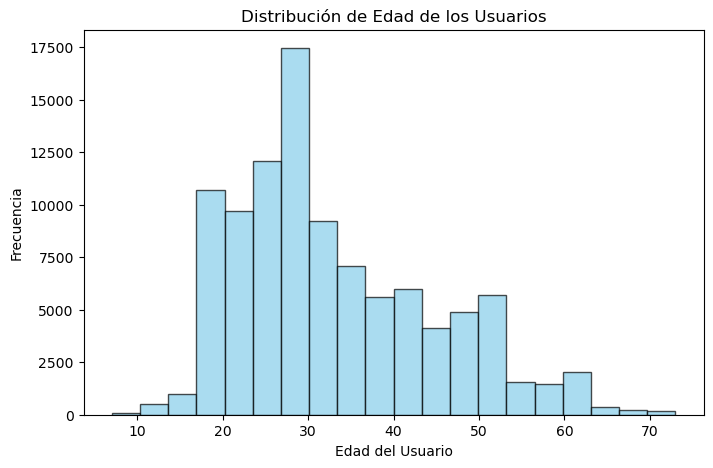

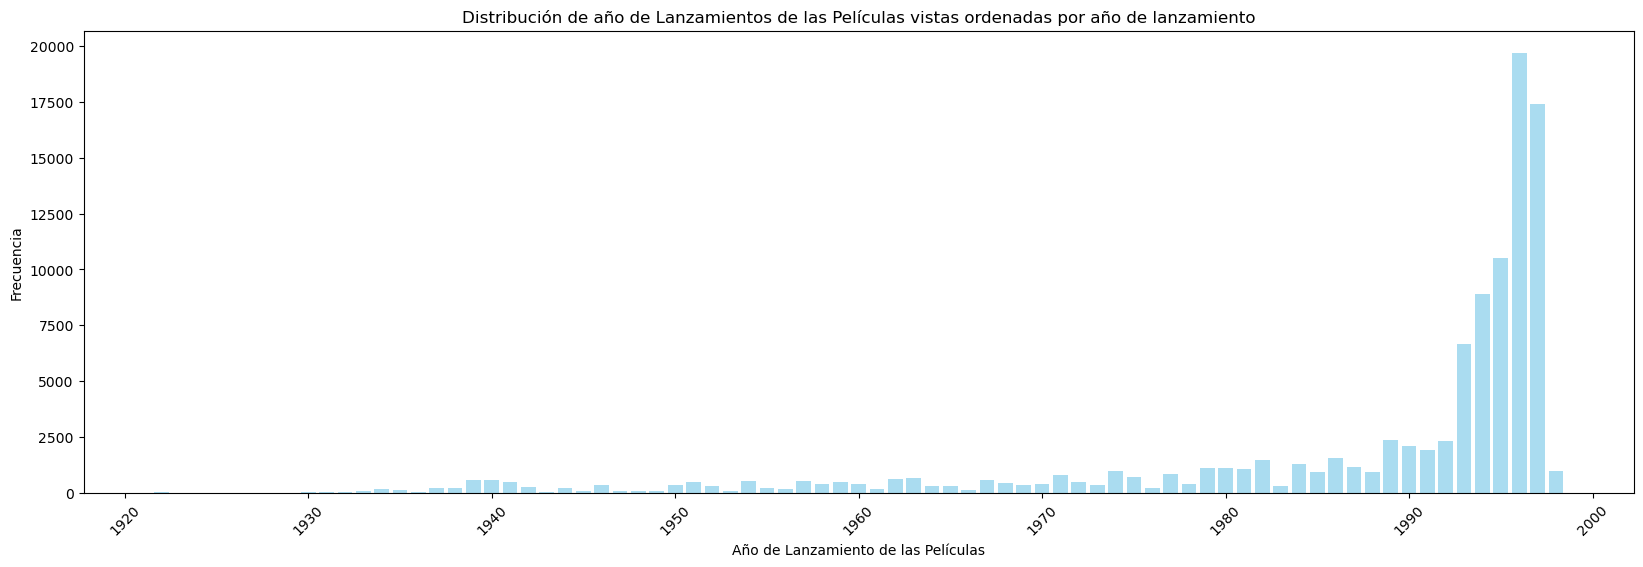

In [126]:
# Distribución de la Edad de los Usuarios
plt.figure(figsize=(8, 5))
plt.hist(df_total['age'], bins=20, edgecolor='k', alpha=0.7, color='skyblue')
plt.xlabel('Edad del Usuario')
plt.ylabel('Frecuencia')
plt.title('Distribución de Edad de los Usuarios')
plt.show()

# Distribución del año de lazamiento de las Películas vistas por los Usuarios
plt.figure(figsize=(20, 6))
df_release = pd.to_datetime( df_total['release_date']).dt.year.value_counts().reset_index() 
df_release["release_date"] = df_release["release_date"].astype(int)
df_release = df_release.sort_values(by = "release_date")
plt.bar(df_release["release_date"], df_release["count"], color='skyblue', alpha=0.7)
plt.xlabel('Año de Lanzamiento de las Películas')
plt.ylabel('Frecuencia')
plt.title('Distribución de año de Lanzamientos de las Películas vistas ordenadas por año de lanzamiento')
plt.xticks(rotation=45)
plt.show()

In [127]:
df_release.release_date.max()

1998

In [128]:
edad_popular = df_total["age"].value_counts().reset_index().iloc[0,:1][0]
cantidad_edad_popular = df_total["age"].value_counts().reset_index().iloc[0,1:][0]

edad_popular_menos = df_total["age"].value_counts().reset_index().iloc[-1,:1][0]
cantidad_edad_popular_menos = df_total["age"].value_counts().reset_index().iloc[-1,1:][0]

In [129]:
release_popular = df_release.sort_values(by="count" , ascending = False).iloc[0,:1][0]
cantidad_release_popular = df_release.sort_values(by="count" , ascending = False).iloc[0,1:][0]

release_popular_menos = df_release.sort_values(by="count" , ascending = False).iloc[-1,:1][0]
cantidad_release_popular_menos = df_release.sort_values(by="count" , ascending = False).iloc[-1,1:][0]

In [130]:
print(f'Valor más popular en la edad es de: {edad_popular} años con {cantidad_edad_popular} apariciones.')
print(f'Valor menos popular en la edad es de: {edad_popular_menos} años con {cantidad_edad_popular_menos} apariciones.')

Valor más popular en la edad es de: 27 años con 6423 apariciones.
Valor menos popular en la edad es de: 11 años con 27 apariciones.


In [131]:
print(f'Valor más popular en año de lanzamiento es: {release_popular} con {cantidad_release_popular} apariciones.')
print(f'Valor menos popular en año de lanzamiento es: {release_popular_menos} con {cantidad_release_popular_menos} apariciones.')

Valor más popular en año de lanzamiento es: 1996 con 19708 apariciones.
Valor menos popular en año de lanzamiento es: 1926 con 2 apariciones.


##### Características de Usuario:

**Género del Usuario:** La información sobre el género del usuario podría ser útil para recomendar contenido que se ajuste a las preferencias de género del usuario.

**Edad del Usuario:** La edad del usuario podría ser relevante para recomendar contenido adecuado para diferentes grupos de edad.

##### Características de Ítem:

**Género de la Película:** El género de la película podría ser relevante para recomendar películas similares en términos de género.

**Año de Lanzamiento de la Película:** El año de lanzamiento podría ser importante para recomendar películas recientes o clásicas según las preferencias del usuario.

##### Análisis de la grafica de dispersión de edad 
La distribución de la edad de los usuarios muestra que la mayoría de los usuarios se encuentran en el rango de edades de 20 a 40 años, lo que sugiere que el conjunto de datos se centra en usuarios jóvenes y de mediana edad. Esta información es útil para comprender la demografía de los usuarios y puede ser relevante al recomendar contenido que se ajuste a diferentes grupos de edad. Además, se ve que el valor más popular en la edad es de: 27 años con 6.423 apariciones y  menos popular de: 11 años con 27 apariciones.
##### Análisis de la grafica de dispersión del año de lanzamiento ordenado 

La distribución del año de lanzamiento de las películas revela que la mayoría de las películas en el conjunto de datos se lanzaron entre los años 1993 y 1997, con un pico en la frecuencia de lanzamiento en ese período. Esto indica que el conjunto de datos incluye principalmente películas lanzadas en ese intervalo de tiempo. Es importante tener en cuenta este rango de años al realizar recomendaciones, ya que las preferencias de los usuarios pueden estar influenciadas por la época en la que se lanzaron las películ Además, se ve que el valor más popular en los años de lanzamiento es 1996 con 19.708 apariciones y menos popular es 1926  con 2 apariciones.

res. La comprensión de la edad de los usuarios y la distribución de años de lanzamiento de las películas puede ayudar a mejorar la precisión de las recomendaciones al considerar las preferencias y la relevancia temporal del contenido.

### Actividad 2: Generación de característica de contexto.

En el ejemplo del tutorial, se generó a partir del timestamp una característica discreta que indicaba si una calificación fue ingresada en la mañana, tarde o noche.

* A partir del timestamp (ya que este es la única característica contextual del dataset), capture otra característica contextual que pueda ser utilizada en el entrenamiento (que no sea una división de mañana/tarde/noche). Justifique su elección explicando por qué se podría aprovechar esa información de contexto para generar mejores recomendaciones. Puede asumir que el timestamp indica la hora en que fue vista la película (en lugar de la hora en la que fue ingresada la calificación) y que todos los usuarios están en la zona horaria entregada por la conversión a dataframe mostrada por la ayudantía.
* Genere una hipótesis de cómo podría influir la variable contextual en la recomendación. (Por ejemplo, una hipótesis podría ser que en la noche, se deberían recomendar una mayor cantidad de películas de terror).

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

In [132]:
df_total['datetime'] = pd.to_datetime(df_total['timestamp'], unit='s')  # Convert the column to datetime format if it's not

# Create new columns
df_total['Month'] = df_total['datetime'].dt.month
df_total.head()

,userid,itemid,rating,timestamp,age,gender,occupation,zip_code,title,release_date,video_release_date,IMDb_URL,unknown,genres,datetime,Month
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,Comedy,1997-12-04 15:55:49,12
1,305,242,5,886307828,23,M,programmer,94086,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,Comedy,1998-02-01 04:37:08,2
2,6,242,4,883268170,42,M,executive,98101,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,Comedy,1997-12-28 00:16:10,12
3,234,242,4,891033261,60,M,retired,94702,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,Comedy,1998-03-27 21:14:21,3
4,63,242,3,875747190,31,M,marketing,75240,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,Comedy,1997-10-01 23:06:30,10


In [133]:
def definir_bloque_estacion(mes):
    if 3 <= mes < 6:
        return 'Primavera'
    elif 6 <= mes < 10:
        return 'Verano'
    elif 10 <= mes < 12:
        return 'Otoño'
    else:
        return 'Invierno'

In [134]:
df_total['Estacion'] = df_total['Month'].apply(definir_bloque_estacion)
df_total.head()

,userid,itemid,rating,timestamp,age,gender,occupation,zip_code,title,release_date,video_release_date,IMDb_URL,unknown,genres,datetime,Month,Estacion
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,Comedy,1997-12-04 15:55:49,12,Invierno
1,305,242,5,886307828,23,M,programmer,94086,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,Comedy,1998-02-01 04:37:08,2,Invierno
2,6,242,4,883268170,42,M,executive,98101,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,Comedy,1997-12-28 00:16:10,12,Invierno
3,234,242,4,891033261,60,M,retired,94702,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,Comedy,1998-03-27 21:14:21,3,Primavera
4,63,242,3,875747190,31,M,marketing,75240,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,Comedy,1997-10-01 23:06:30,10,Otoño


#### Contexto por estaciones del año

In [137]:
df_total[df_total["Estacion"]=="Invierno"].genres.value_counts()	

genres
Drama                                4898
Comedy                               3663
Comedy|Romance                       1828
Drama|Romance                        1696
Action|Thriller                      1359
                                     ... 
Comedy|Mystery|Romance                  3
Action|Adventure|Children|Fantasy       2
Action|Comedy|Crime|Drama               1
Action|Adventure|Children               1
Fantasy                                 1
Name: count, Length: 211, dtype: int64

Supondremos que la información es información de Europeos, por lo cual van a tener las siguientes estaciones del año que afectarían la recomendación debido a los efectos del estado del animo de las personas a razón del clima que tendría cada estación:

* La primavera comprende marzo, abril y mayo.
* El verano, por su parte, está formado por los mesese de junio, julio, agosto y septiembre.
* El otoño se compone octubre y noviembre.
* Por último, la estación del invierno comprende diciembre, enero y febrero.

Nuestra hipotesis plantea que en  invierno los usuarios vendría más peliculas de Comedia para subirse el animo.

### Actividad 3: Entrenamiento Modelos.

Entrene modelos de recomendación utilizando la librería DeepCTR-torch.

* El primer modelo debe contener solo la información de las interacciones, es decir, usuario, item y rating.
* Al segundo modelo se le deben agregar las caracterísitcas de contenido.
* El tercer modelo debe tener la característica contextual.

Recuerde que antes de entrenar, se debe generar la división train-test del dataset.

Recuerde variar los hiperparámetros para obtener mejores resultados y entrene por al menos 12 épocas cada modelo.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

### Actividad 4: Evaluación de rendimiento.

Genere una tabla comparando el rendimiento de los tres modelos generados. Evalúe con la métrica AUC y MSE. Comente qué método obtuvo el mejor resultado.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

### Actividad 5: Evaluación de hipótesis.

Realice una evaluación de la hipótesis que generó en la Actividad 2 en base a las recomendaciones que entrega su modelo contextual. Por ejemplo, para evaluar la hipótesis dada de ejemplo en la Actividad 2, se podrían analizar las recomendaciones dadas a usuarios en distintos bloques horarios y analizar si en el bloque nocturno existe una mayor densidad de películas de terror.

Comente respecto al resultado de su evaluación. Recuerde que la hipótesis no necesariamente debe estar correcta, en especial debido a los supuestos realizados en el entrenamiento. Sugiera una posible mejoría al diseño experimental para poder obtener un mejor análisis de su hipótesis.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.